In [2]:
import pandas as pd
from file_paths_and_consts import *
import geopandas as gpd
import os
OUTPUT_DIR

'/project/biocomplexity/UKR_forecast/migration_data/output_data_2024/'

In [3]:
def calc_hazard(lmbda,gamma,conflict_at_t,discounted_conflict,delt,function_type='constant'):
    if delt<0:
        print('here1')
        return 0
    if function_type=='constant':
        print('here2')
        return purifier(lmbda)
    elif function_type=='constant_conflict' or 'constant_global_conflict' or 'constant_global_conflict_intensity':
        print('here3')
        return purifier(lmbda*(1-conflict_at_t))
    elif function_type=='constant_global_conflict_weighted_intensity':
        print('here4')
        return purifier(lmbda*(1-gamma*conflict_at_t))
    elif function_type=='constant_discounted_conflict':
        print('here5')
        return purifier(lmbda*(1-discounted_conflict))
    elif function_type=='weibull_conflict':
        print('here6')
        return purifier(lmbda*gamma*(delt*(1-conflict_at_t))**(gamma-1))
    else:
        raise NotImplementedError

In [5]:
## SVK Border Guard Data

In [10]:
import json

with open('/project/biocomplexity/UKR_forecast/migration_data/gtruth_from_various_source/slovak_border_movement.json', 'r') as file:
    data = json.load(file)

# Print the data
df = pd.DataFrame.from_dict(data['data']['timeseries'])
df['data_date'] = pd.to_datetime(df['data_date'])
df = df[df.data_date<=pd.to_datetime('2022-08-01')]
df['individuals'] = df['individuals'].rolling(15).mean()
df = df.dropna(subset='individuals')
svk_ukr_depart_df = df.copy()

In [11]:
#svk_ukr_depart_df = svk_ukr_depart_df[svk_ukr_depart_df.data_date>=pd.to_datetime('2022-04-01')]


In [12]:
svk_ukr_depart_df['individuals'].sum()

np.float64(373646.4)

In [4]:
# import matplotlib.pyplot as plt
# fig,ax = plt.subplots(figsize=(8,5))
# ax.scatter(svk_ukr_depart_df['data_date'],svk_ukr_depart_df['individuals'])

## POLAND BORDER GUARD DATA

In [5]:
import pandas as pd
import matplotlib.pyplot as plt


#pl_border_data = pd.read_csv('/project/biocomplexity/UKR_forecast/migration_data/gtruth_from_various_source/poland_border_movement_utf8.csv',thousands=',')
pl_border_data = pd.read_csv('../../old_scripts/Diff_source_data_study/poland_border_movement_utf8.csv',thousands=',')
#ukr_people_arrive_poland_by_date = ukr_people_arrive_poland_by_date.dropna(subset=['Total'])
pl_border_data['Date'] = pd.to_datetime(pl_border_data['Date'])
ukr_people_arrive_poland_by_date = ((pl_border_data[(pl_border_data.Direction=='Arrival to Poland') & (pl_border_data['Citizenship (Code)']=='UA')]).groupby('Date')['Total'].sum()).reset_index()
ukr_people_arrive_poland_by_date = ukr_people_arrive_poland_by_date.sort_values(by='Date')

ukr_people_depart_poland_by_date = ((pl_border_data[(pl_border_data.Direction=='Departure from Poland') & (pl_border_data['Citizenship (Code)']=='UA')]).groupby('Date')['Total'].sum()).reset_index()
ukr_people_depart_poland_by_date = ukr_people_depart_poland_by_date.sort_values(by='Date')

ukr_people_arrive_poland_by_date['Total'] = ukr_people_arrive_poland_by_date['Total'].rolling(15).mean()
ukr_people_depart_poland_by_date['Total'] = ukr_people_depart_poland_by_date['Total'].rolling(15).mean()
ukr_people_arrive_poland_by_date = ukr_people_arrive_poland_by_date.dropna(subset='Total')
ukr_people_depart_poland_by_date = ukr_people_depart_poland_by_date.dropna(subset='Total')
ukr_people_arrive_poland_by_date =  ukr_people_arrive_poland_by_date.rename(columns={'Total':'Arrival'})
ukr_people_depart_poland_by_date =  ukr_people_depart_poland_by_date.rename(columns={'Total':'Depart'})


/tmp/ipykernel_325525/4005042868.py:6: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  pl_border_data = pd.read_csv('../../old_scripts/Diff_source_data_study/poland_border_movement_utf8.csv',thousands=',')


## HELPER FUNCTIONS

In [6]:
def get_single_raion_dataframes(RETURN_DIRS,raion_name,sim_idx,param_idx_left,param_idx_right,Q1=0.2,Q3=0.8,SEED_MAX=3):
    all_dfs = []
    for i in range(param_idx_left,param_idx_right):
        seeded_return_df = []
        for seed in range(0,SEED_MAX):
            fname = f'mim_hid_return_{raion_name}_SIM_{sim_idx}_SEED_{seed}.csv'
            if os.path.isfile(OUTPUT_DIR+RETURN_DIRS[i]+fname):
                #print(fname,'exists in',RETURN_DIRS[i])
                df = pd.read_csv(OUTPUT_DIR+RETURN_DIRS[i]+fname)
                df['Total'] = df[DEMO_TYPES].sum(axis=1)
                df['return_date'] = pd.to_datetime(df['return_date'])
                return_df = df.groupby('return_date')['Total'].sum().reset_index()
                return_df = df.groupby('return_date')['Total'].sum().reset_index()
                return_df['Total'] = return_df['Total'].rolling(7).mean()
                return_df = return_df.dropna(subset=['Total'])
                seeded_return_df.append(return_df)
        seed_df = pd.concat(seeded_return_df)
        seed_median_df = seed_df.groupby('return_date')['Total'].quantile(q=0.5).reset_index()
        seed_q1_df = (seed_df.groupby('return_date')['Total'].quantile(q=Q1).reset_index()).rename(columns={'Total':'q1'})
        seed_q3_df = (seed_df.groupby('return_date')['Total'].quantile(q=Q3).reset_index()).rename(columns={'Total':'q3'})
        seed_uncertain_df = (seed_median_df.merge(seed_q1_df,on='return_date',how='inner')).merge(seed_q3_df,on='return_date',how='inner')
        all_dfs.append(seed_uncertain_df)
    return all_dfs

def get_whole_UKR_dataframes_from_dest(RETURN_DIRS,all_raions,dest_name,sim_idx,param_idx_left,param_idx_right,Q1=0.2,Q3=0.8,SEED_MAX=3,cache_clean_mode=0):
    all_dfs = []
    for i in range(param_idx_left,param_idx_right):
        cache_file_name = f'return_from_{dest_name}_to_UKR_result_SIM_{sim_idx}_from_{RETURN_DIRS[i][:-1]}.csv'
        if os.path.isfile(CACHE_DIR+cache_file_name) and cache_clean_mode==0:
            #print('cached',cache_file_name,'found')
            df = pd.read_csv(CACHE_DIR+cache_file_name)
            df['return_date'] = pd.to_datetime(df['return_date'])
            all_dfs.append(df)
            continue
        seeded_return_df = []
        for seed in range(0,SEED_MAX):
            cur_settings_df = []
            for raion_idx in range(0,len(all_raions)):
                raion_name = all_raions[raion_idx]
                fname = f'mim_hid_return_{raion_name}_SIM_{sim_idx}_SEED_{seed}.csv'
                if os.path.isfile(OUTPUT_DIR+RETURN_DIRS[i]+fname):
                    #print(raion_name,'exists in',RETURN_DIRS[i])
                    df = pd.read_csv(OUTPUT_DIR+RETURN_DIRS[i]+fname)
                    df = df[df.dest==dest_name]
                    df['Total'] = df[DEMO_TYPES].sum(axis=1)
                    df['return_date'] = pd.to_datetime(df['return_date'])
                    return_df = df.groupby('return_date')['Total'].sum().reset_index()
                    return_df['Total'] = return_df['Total'].rolling(7).mean()
                    return_df = return_df.dropna(subset=['Total'])
                    cur_settings_df.append(return_df)
            if len(cur_settings_df)>0:
                all_return_df = pd.concat(cur_settings_df)
                all_return_df = all_return_df.groupby('return_date')['Total'].sum().reset_index()
                seeded_return_df.append(all_return_df)
        seed_df = pd.concat(seeded_return_df)
        seed_median_df = seed_df.groupby('return_date')['Total'].quantile(q=0.5).reset_index()
        seed_q1_df = (seed_df.groupby('return_date')['Total'].quantile(q=Q1).reset_index()).rename(columns={'Total':'q1'})
        seed_q3_df = (seed_df.groupby('return_date')['Total'].quantile(q=Q3).reset_index()).rename(columns={'Total':'q3'})
        seed_uncertain_df = (seed_median_df.merge(seed_q1_df,on='return_date',how='inner')).merge(seed_q3_df,on='return_date',how='inner')
        seed_uncertain_df.to_csv(CACHE_DIR+cache_file_name,index=False)
        all_dfs.append(seed_uncertain_df)
        #all_dfs.append(all_return_df)
    return all_dfs

def get_single_raion_refugee(raion_name,sim_idx):
    refugee_df = pd.read_csv(OUTPUT_DIR+f'mim_hid_completed_{raion_name}_{sim_idx}.csv')
    refugee_df = refugee_df[refugee_df.move_type==2]
    refugee_df['move_date'] = pd.to_datetime(refugee_df['move_date'])
    refugee_df['Total'] = refugee_df[DEMO_TYPES].sum(axis=1)
    refugee_daily_df = refugee_df.groupby('move_date')['Total'].sum().reset_index()
    refugee_daily_df['Total'] = refugee_daily_df['Total'].rolling(1).mean()
    refugee_daily_df = refugee_daily_df.dropna(subset=['Total'])
    return refugee_daily_df

def plot_migrant_simulations(ax,return_dfs,param_name,param_vals,lgd_params,peer_added=True,apply_cumulative=False,migrant_type='returnee',scale=1000,scaletype='K'):
    assert len(return_dfs)==len(param_vals)
    marker = 'P' if peer_added else 'o'
    p_status = 'Peer Added' if peer_added else ''
    for idx,p in enumerate(param_vals):
        return_dfs[idx]['Total'] = return_dfs[idx]['Total'].cumsum() if apply_cumulative else return_dfs[idx]['Total']
        return_dfs[idx]['q1'] = return_dfs[idx]['q1'].cumsum() if apply_cumulative else return_dfs[idx]['q1']
        return_dfs[idx]['q3'] = return_dfs[idx]['q3'].cumsum() if apply_cumulative else return_dfs[idx]['q3']
        label = f'{param_name} = {p} '
        try:
            ax.plot(return_dfs[idx]['return_date'],return_dfs[idx]['Total']/scale,label=label,marker=marker,markevery=10,linewidth=1)
            ax.fill_between(return_dfs[idx]['return_date'],return_dfs[idx]['q1']/scale,return_dfs[idx]['q3']/scale,alpha=0.6)
        except Exception as e:
            print(e)
            continue
    ax.set_xlabel('Time')
    ax.set_ylabel(f'{migrant_type} ({scaletype})')
    ax.legend(loc="best", fancybox=True, handlelength=lgd_params['hlen'], borderpad=lgd_params['bpad'], labelspacing=lgd_params['lspace'],
                  handletextpad = lgd_params['htxtpad'], borderaxespad = lgd_params['baxpad'], columnspacing = lgd_params['cspace'],
                  ncol=lgd_params['ncol'], edgecolor=lgd_params['ecolor'], frameon=True, framealpha=lgd_params['alpha'], shadow=True, prop={'size': lgd_params['size']})
    return


def plot_migrant_simulations_ensemble(ax,sim_idx,return_dfs,param_name,param_vals,lgd_params,peer_added=True,apply_cumulative=False,migrant_type='returnee',scale=1000,scaletype='K'):
    assert len(return_dfs)==len(param_vals)
    marker = 'P' if peer_added else 'o'
    p_status = 'Peer Added' if peer_added else ''
    for idx,p in enumerate(param_vals):
        return_dfs[idx]['Total'] = return_dfs[idx]['Total'].cumsum() if apply_cumulative else return_dfs[idx]['Total']
        return_dfs[idx]['q1'] = return_dfs[idx]['q1'].cumsum() if apply_cumulative else return_dfs[idx]['q1']
        return_dfs[idx]['q3'] = return_dfs[idx]['q3'].cumsum() if apply_cumulative else return_dfs[idx]['q3']
        label = f'{param_name} = {p} '
        try:
            ax.plot(return_dfs[idx]['return_date'],return_dfs[idx]['Total']/scale,label='Sim: '+str(int(sim_idx)),marker=marker,markevery=10,linewidth=1)
            ax.fill_between(return_dfs[idx]['return_date'],return_dfs[idx]['q1']/scale,return_dfs[idx]['q3']/scale,alpha=0.6)
        except Exception as e:
            print(e)
            continue
    ax.set_xlabel('Time')
    ax.set_ylabel(f'{migrant_type} ({scaletype})')
    #ax.legend(loc="best", fancybox=True, handlelength=lgd_params['hlen'], borderpad=lgd_params['bpad'], labelspacing=lgd_params['lspace'],
    #              handletextpad = lgd_params['htxtpad'], borderaxespad = lgd_params['baxpad'], columnspacing = lgd_params['cspace'],
    #              ncol=lgd_params['ncol'], edgecolor=lgd_params['ecolor'], frameon=True, framealpha=lgd_params['alpha'], shadow=True, prop={'size': lgd_params['size']})
    return

def compare(simulation_dfs, observed_df, observe_col, date_start, date_end, sim_date_col, observe_date_col, param_vals):
    for idx,p in enumerate(param_vals):
        merged_df = simulation_dfs[idx].merge(observed_df,left_on=sim_date_col,right_on=observe_date_col,how='inner')
        merged_df = merged_df[(merged_df[sim_date_col]>=pd.to_datetime(date_start)) & (merged_df[sim_date_col]<=pd.to_datetime(date_end))]
        mse = (((merged_df['Total']-merged_df[observe_col])**2).sum())/merged_df.shape[0]
        corr = merged_df['Total'].corr(merged_df[observe_col], method='pearson')
        rmse = mse**0.5
        #print(p,'rmse:',rmse,'corr:',corr)
        print(corr)
    return

## with Hazard Function -- Constant

In [7]:
BASE_DIR = '/project/biocomplexity/UKR_forecast/migration_data/'
geo_shp_file = BASE_DIR+'raw_data/UKR_shapefile_2/ukr_shp/ukr_admbnda_adm2_sspe_20230201.shp'
ukr_gdf = gpd.read_file(geo_shp_file)

all_raions = ukr_gdf['ADM2_EN'].tolist()
raion_name = all_raions[78]
print(raion_name)

sim_idx = str(11).zfill(9)
scale = 1000

# single_raion_df_hazard = get_single_raion_dataframes(RETURN_DIRS_HAZARD,raion_name,sim_idx,0,len(constant_HS),SEED_MAX=1,Q1=0.1,Q3=0.9)

# all_dfs_hazard = get_whole_UKR_dataframes_from_dest(RETURN_DIRS_HAZARD,all_raions,'PL',sim_idx,0,len(constant_HS),SEED_MAX=1,Q1=0.1,Q3=0.9)


refugee_daily_df = get_single_raion_refugee(raion_name,sim_idx)

ERROR 1: PROJ: proj_create_from_database: Open of /home/zm8bh/.conda/envs/migration_env/share/proj failed


Lvivskyi


In [8]:
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# fig,ax = plt.subplots(1,2,figsize=(6*2,3))


# LEGEND_PARAMS = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':2,'ecolor':'black','size':12,'alpha':0.2}

# ax[0].plot(refugee_daily_df['move_date'],(refugee_daily_df['Total'].cumsum())/scale,label='Refugee Sim',color='red',marker='X')
# ax[0].set_xlim([pd.to_datetime('2022-02-01'),pd.to_datetime('2022-09-01')])
# plot_migrant_simulations(ax[0],single_raion_df_hazard,'H',constant_HS,LEGEND_PARAMS,peer_added=False,apply_cumulative=True,migrant_type='Returnee (Cumulative)')
# ax[0].set_title(f'Src: {raion_name} Dest: All, ABSCIM SIM: {sim_idx}')
# #ax[0].set_ylim([None,50000])

# ax[1].plot(ukr_people_depart_poland_by_date['Date'],ukr_people_depart_poland_by_date['Depart']/scale,label='PL->UA',color='green',linewidth=2)
# ax[1].set_xlim([pd.to_datetime('2022-04-01'),pd.to_datetime('2022-08-01')])
# plot_migrant_simulations(ax[1],all_dfs_hazard,'H',constant_HS,LEGEND_PARAMS,peer_added=False,apply_cumulative=False,migrant_type='Returnee')
# #plot_migrant_simulations(ax[1],all_dfs_with_peer,'W',SCALE_WEIGHT,LEGEND_PARAMS,peer_added=True,apply_cumulative=False,migrant_type='Returnee')
# ax[1].set_title(f'Src: UA Dest: PL, ABSCIM SIM: {sim_idx}')
# #ax[1].set_ylim([None,50000])

# myFmt = mdates.DateFormatter('%m/%d')
# ax[1].xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
# ax[1].xaxis.set_major_formatter(myFmt)
# ax[0].xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
# ax[0].xaxis.set_major_formatter(myFmt)

## READ ALL RAION

In [9]:
BASE_DIR = '/project/biocomplexity/UKR_forecast/migration_data/'
geo_shp_file = BASE_DIR+'raw_data/UKR_shapefile_2/ukr_shp/ukr_admbnda_adm2_sspe_20230201.shp'
ukr_gdf = gpd.read_file(geo_shp_file)
all_raions = ukr_gdf['ADM2_EN'].tolist()
raion_name = all_raions[78]
print(raion_name)

Lvivskyi


In [10]:
def get_ensemble_return_from_dest_for_param(RETURN_DIR_PARAM,all_sims,dest,all_raions,q1=0.2,q3=0.8,cache_clean_mode=0):
    cache_file_name = f'return_from_{dest}_to_UKR_ensemble_{q1}_to_{q3}_selected_SIM_with_{RETURN_DIR_PARAM[0][:-1]}.csv'
    print(CACHE_DIR+cache_file_name)
    if os.path.isfile(CACHE_DIR+cache_file_name) and cache_clean_mode==0:
        print('ensemble cache found for',dest,RETURN_DIR_PARAM[0][:-1])
        df = pd.read_csv(CACHE_DIR+cache_file_name)
        df['return_date'] = pd.to_datetime(df['return_date'])
        return df
    all_return_sims = []
    for sim in all_sims:
        try:
            sim_idx = str(sim).zfill(9)
            return_df = get_whole_UKR_dataframes_from_dest(RETURN_DIR_PARAM,all_raions,dest,sim_idx,0,1,SEED_MAX=1,Q1=0.1,Q3=0.9,cache_clean_mode=cache_clean_mode)[0][['return_date','Total']]
            all_return_sims.append(return_df)
        except:
            continue
    
    tot_return_df_mid = (pd.concat(all_return_sims).groupby('return_date'))['Total'].quantile(0.5).reset_index()
    tot_return_df_q1 = ((pd.concat(all_return_sims).groupby('return_date'))['Total'].quantile(q1).reset_index()).rename(columns={'Total':'q1'})
    tot_return_df_q3 = ((pd.concat(all_return_sims).groupby('return_date'))['Total'].quantile(q3).reset_index()).rename(columns={'Total':'q3'})
    
    tot_return_df_with_quantile = (tot_return_df_mid.merge(tot_return_df_q1,on='return_date',how='inner')).merge(tot_return_df_q3,how='inner',on='return_date')
    tot_return_df_with_quantile.to_csv(CACHE_DIR+cache_file_name,index=False)
    return tot_return_df_with_quantile

def calc_error(sim_data,gt_data,gt_cols=['Date','Total'],date_start='2022-04-01',date_end='2022-08-01',gt_scale=1.0):
    cur_sim_data = sim_data[(sim_data['return_date']>=pd.to_datetime(date_start)) & (sim_data['return_date']<=pd.to_datetime(date_end))]
    cur_gt_data = gt_data[(gt_data[gt_cols[0]]>=pd.to_datetime(date_start)) & (gt_data[gt_cols[0]]<=pd.to_datetime(date_end))]
    cur_gt_data[gt_cols[1]] = cur_gt_data[gt_cols[1]]/gt_scale
    compare_data = cur_sim_data.merge(cur_gt_data,left_on='return_date',right_on=gt_cols[0],how='inner')
    rmse = (sum((compare_data[gt_cols[1]]-compare_data['Total'])**2)/compare_data.shape[0])**0.5
    nrmse = rmse/(max(compare_data[gt_cols[1]])-min(compare_data[gt_cols[1]]))
    pcc = compare_data[gt_cols[1]].corr(compare_data['Total'])
    return f'rmse = {rmse}, nrmse = {nrmse}, pcc = {pcc}'

## multiple simulations -- constant hazard

/project/biocomplexity/UKR_forecast/migration_data/cached_analysis_data/return_from_PL_to_UKR_ensemble_0.1_to_0.9_selected_SIM_with_RETURN_HAZARD_constant_0.0001.csv
/project/biocomplexity/UKR_forecast/migration_data/cached_analysis_data/return_from_SK_to_UKR_ensemble_0.1_to_0.9_selected_SIM_with_RETURN_HAZARD_constant_0.0001.csv
h= 0.0001
rmse = 3584.106233173573, nrmse = 0.2730008048491596, pcc = 0.9123505478435916 PL
rmse = 596.2300957275072, nrmse = 0.31495462163377264, pcc = 0.9392763172165276 SK
/project/biocomplexity/UKR_forecast/migration_data/cached_analysis_data/return_from_PL_to_UKR_ensemble_0.1_to_0.9_selected_SIM_with_RETURN_HAZARD_constant_0.00015.csv


/tmp/ipykernel_56841/1509683363.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_gt_data[gt_cols[1]] = cur_gt_data[gt_cols[1]]/gt_scale
/tmp/ipykernel_56841/1509683363.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_gt_data[gt_cols[1]] = cur_gt_data[gt_cols[1]]/gt_scale


/project/biocomplexity/UKR_forecast/migration_data/cached_analysis_data/return_from_SK_to_UKR_ensemble_0.1_to_0.9_selected_SIM_with_RETURN_HAZARD_constant_0.00015.csv
h= 0.00015
rmse = 1707.8875311903028, nrmse = 0.13008952309818905, pcc = 0.9318306712849896 PL
rmse = 311.5740443493013, nrmse = 0.16458693707703617, pcc = 0.9246473953581215 SK
/project/biocomplexity/UKR_forecast/migration_data/cached_analysis_data/return_from_PL_to_UKR_ensemble_0.1_to_0.9_selected_SIM_with_RETURN_HAZARD_constant_0.0002.csv


/tmp/ipykernel_56841/1509683363.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_gt_data[gt_cols[1]] = cur_gt_data[gt_cols[1]]/gt_scale
/tmp/ipykernel_56841/1509683363.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_gt_data[gt_cols[1]] = cur_gt_data[gt_cols[1]]/gt_scale


/project/biocomplexity/UKR_forecast/migration_data/cached_analysis_data/return_from_SK_to_UKR_ensemble_0.1_to_0.9_selected_SIM_with_RETURN_HAZARD_constant_0.0002.csv
h= 0.0002
rmse = 3506.942318818866, nrmse = 0.2671232416985011, pcc = 0.8095599093537289 PL
rmse = 576.4353549003962, nrmse = 0.30449818014882174, pcc = 0.786359464157236 SK


/tmp/ipykernel_56841/1509683363.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_gt_data[gt_cols[1]] = cur_gt_data[gt_cols[1]]/gt_scale
/tmp/ipykernel_56841/1509683363.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_gt_data[gt_cols[1]] = cur_gt_data[gt_cols[1]]/gt_scale


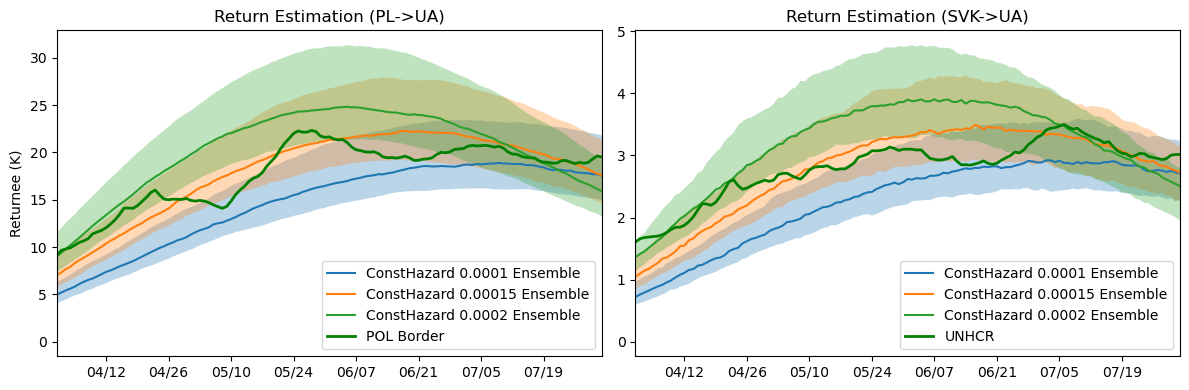

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

all_sims = range(0,100)
fig,ax = plt.subplots(1,2,figsize=(6*2,4))
LEGEND_PARAMS = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':2,'ecolor':'black','size':12,'alpha':0.2}

myFmt = mdates.DateFormatter('%m/%d')

Q1 = 0.25
Q3 = 0.75

scale = 1e3

H_Rates = [0.0001,0.00015,0.0002]
#H_Rates = [0.00015]
RETURN_DIRS = [f'RETURN_HAZARD_constant_{h}/' for h in H_Rates]
#print(RETURN_DIRS)

all_ensembles = []

for idx, r in enumerate(RETURN_DIRS):
    #print(r)
    return_ensemble_PL = get_ensemble_return_from_dest_for_param([r],all_sims,'PL',all_raions,q1=0.1,q3=0.9,cache_clean_mode=1)
    return_ensemble_SK = get_ensemble_return_from_dest_for_param([r],all_sims,'SK',all_raions,q1=0.1,q3=0.9,cache_clean_mode=1)
    ax[0].plot(return_ensemble_PL['return_date'],return_ensemble_PL['Total']/(scale),label=f'ConstHazard {H_Rates[idx]} Ensemble')
    ax[0].fill_between(return_ensemble_PL['return_date'],return_ensemble_PL['q1']/(scale),return_ensemble_PL['q3']/(scale),alpha=0.3)
    ax[1].plot(return_ensemble_SK['return_date'],return_ensemble_SK['Total']/(scale),label=f'ConstHazard {H_Rates[idx]} Ensemble')
    ax[1].fill_between(return_ensemble_SK['return_date'],return_ensemble_SK['q1']/(scale),return_ensemble_SK['q3']/(scale),alpha=0.3)
    print('h=',H_Rates[idx])
    all_ensembles.append(return_ensemble_PL)
    print(calc_error(return_ensemble_PL,ukr_people_depart_poland_by_date,gt_cols=['Date','Depart'],gt_scale=1.2),'PL')
    print(calc_error(return_ensemble_SK,svk_ukr_depart_df,gt_cols=['data_date','individuals']),'SK')

ax[0].plot(ukr_people_depart_poland_by_date['Date'],ukr_people_depart_poland_by_date['Depart']/(1.0*scale*1.2),label='POL Border',color='green',linewidth=2)  
ax[1].plot(svk_ukr_depart_df['data_date'],svk_ukr_depart_df['individuals']/(1.0*scale),label='UNHCR',color='green',linewidth=2)

myFmt = mdates.DateFormatter('%m/%d')
for i in range(2):
    ax[i].legend(loc='best')
    ax[i].xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    ax[i].xaxis.set_major_formatter(myFmt)
    ax[i].set_xlim([pd.to_datetime('2022-04-01'),pd.to_datetime('2022-08-01')])
ax[0].set_title(f'Return Estimation (PL->UA)')
ax[1].set_title(f'Return Estimation (SVK->UA)')
ax[0].set_ylabel('Returnee (K)')

fig.tight_layout()
#fig.savefig('return_constant_hazard.png',dpi=350,bbox_inches='tight')

/project/biocomplexity/UKR_forecast/migration_data/cached_analysis_data/return_from_PL_to_UKR_ensemble_0.1_to_0.9_selected_SIM_with_RETURN_HAZARD_constant_conflict_0.00015.csv
ensemble cache found for PL RETURN_HAZARD_constant_conflict_0.00015
/project/biocomplexity/UKR_forecast/migration_data/cached_analysis_data/return_from_SK_to_UKR_ensemble_0.1_to_0.9_selected_SIM_with_RETURN_HAZARD_constant_conflict_0.00015.csv
ensemble cache found for SK RETURN_HAZARD_constant_conflict_0.00015
['RETURN_HAZARD_constant_global_conflict_0.00015/']
/project/biocomplexity/UKR_forecast/migration_data/cached_analysis_data/return_from_PL_to_UKR_ensemble_0.1_to_0.9_selected_SIM_with_RETURN_HAZARD_constant_global_conflict_0.00015.csv
ensemble cache found for PL RETURN_HAZARD_constant_global_conflict_0.00015
/project/biocomplexity/UKR_forecast/migration_data/cached_analysis_data/return_from_SK_to_UKR_ensemble_0.1_to_0.9_selected_SIM_with_RETURN_HAZARD_constant_global_conflict_0.00015.csv
ensemble cache foun

/tmp/ipykernel_325525/1509683363.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_gt_data[gt_cols[1]] = cur_gt_data[gt_cols[1]]/gt_scale
/tmp/ipykernel_325525/1509683363.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_gt_data[gt_cols[1]] = cur_gt_data[gt_cols[1]]/gt_scale


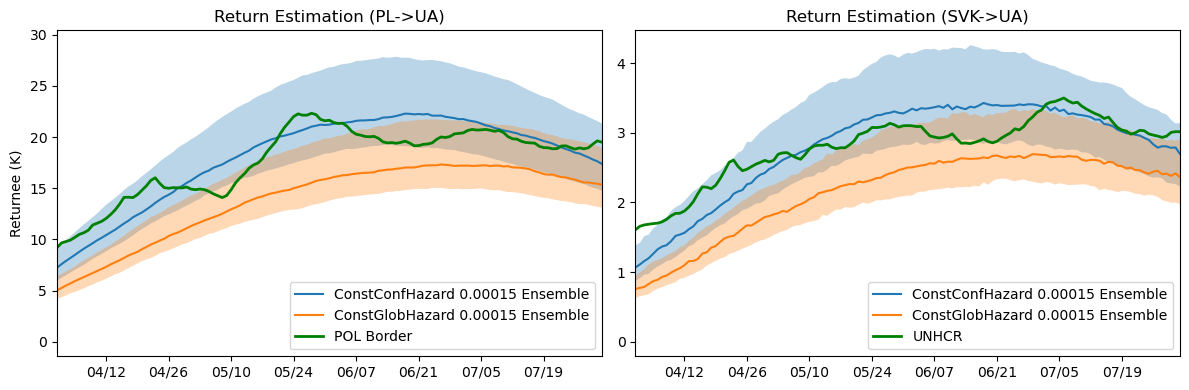

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

all_sims = range(0,100)
fig,ax = plt.subplots(1,2,figsize=(6*2,4))
LEGEND_PARAMS = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':2,'ecolor':'black','size':12,'alpha':0.2}

myFmt = mdates.DateFormatter('%m/%d')

Q1 = 0.25
Q3 = 0.75

scale = 1e3

#H_Rates = [0.0001,0.00015,0.0002]
# H_Rates = [0.00015]
# RETURN_DIRS = [f'RETURN_HAZARD_constant_{h}/' for h in H_Rates]
# #print(RETURN_DIRS)

# for idx, r in enumerate(RETURN_DIRS):
#     #print(r)
#     return_ensemble_PL = get_ensemble_return_from_dest_for_param([r],all_sims,'PL',all_raions,q1=0.1,q3=0.9,cache_clean_mode=0)
#     return_ensemble_SK = get_ensemble_return_from_dest_for_param([r],all_sims,'SK',all_raions,q1=0.1,q3=0.9,cache_clean_mode=0)
#     ax[0].plot(return_ensemble_PL['return_date'],return_ensemble_PL['Total']/(scale),label=f'ConstHazard {H_Rates[idx]} Ensemble')
#     ax[0].fill_between(return_ensemble_PL['return_date'],return_ensemble_PL['q1']/(scale),return_ensemble_PL['q3']/(scale),alpha=0.3)
#     ax[1].plot(return_ensemble_SK['return_date'],return_ensemble_SK['Total']/(scale),label=f'ConstHazard {H_Rates[idx]} Ensemble')
#     ax[1].fill_between(return_ensemble_SK['return_date'],return_ensemble_SK['q1']/(scale),return_ensemble_SK['q3']/(scale),alpha=0.3)
#     print('h=',H_Rates[idx])
#     print(calc_error(return_ensemble_PL,ukr_people_depart_poland_by_date,gt_cols=['Date','Depart'],gt_scale=1.2),'PL')
#     print(calc_error(return_ensemble_SK,svk_ukr_depart_df,gt_cols=['data_date','individuals']),'SK')

#H_Rates = [0.0001,0.00015,0.0002]
H_Rates = [0.00015]
RETURN_DIRS = [f'RETURN_HAZARD_constant_conflict_{h}/' for h in H_Rates]
#print(RETURN_DIRS)

for idx, r in enumerate(RETURN_DIRS):
    #print(r)
    return_ensemble_PL = get_ensemble_return_from_dest_for_param([r],all_sims,'PL',all_raions,q1=0.1,q3=0.9,cache_clean_mode=0)
    return_ensemble_SK = get_ensemble_return_from_dest_for_param([r],all_sims,'SK',all_raions,q1=0.1,q3=0.9,cache_clean_mode=0)
    ax[0].plot(return_ensemble_PL['return_date'],return_ensemble_PL['Total']/(scale),label=f'ConstConfHazard {H_Rates[idx]} Ensemble')
    ax[0].fill_between(return_ensemble_PL['return_date'],return_ensemble_PL['q1']/(scale),return_ensemble_PL['q3']/(scale),alpha=0.3)
    ax[1].plot(return_ensemble_SK['return_date'],return_ensemble_SK['Total']/(scale),label=f'ConstConfHazard {H_Rates[idx]} Ensemble')
    ax[1].fill_between(return_ensemble_SK['return_date'],return_ensemble_SK['q1']/(scale),return_ensemble_SK['q3']/(scale),alpha=0.3)
    #print('h=',H_Rates[idx])
    #print(calc_error(return_ensemble_PL,ukr_people_depart_poland_by_date,gt_cols=['Date','Depart'],gt_scale=1.2),'PL')
    #print(calc_error(return_ensemble_SK,svk_ukr_depart_df,gt_cols=['data_date','individuals']),'SK')
    
#H_Rates = [0.0001,0.00015,0.0002]
H_Rates = [0.00015]
RETURN_DIRS = [f'RETURN_HAZARD_constant_global_conflict_{h}/' for h in H_Rates]
print(RETURN_DIRS)

for idx, r in enumerate(RETURN_DIRS):
    #print(r)
    return_ensemble_PL = get_ensemble_return_from_dest_for_param([r],all_sims,'PL',all_raions,q1=0.1,q3=0.9,cache_clean_mode=0)
    return_ensemble_SK = get_ensemble_return_from_dest_for_param([r],all_sims,'SK',all_raions,q1=0.1,q3=0.9,cache_clean_mode=0)
    ax[0].plot(return_ensemble_PL['return_date'],return_ensemble_PL['Total']/(scale),label=f'ConstGlobHazard {H_Rates[idx]} Ensemble')
    ax[0].fill_between(return_ensemble_PL['return_date'],return_ensemble_PL['q1']/(scale),return_ensemble_PL['q3']/(scale),alpha=0.3)
    ax[1].plot(return_ensemble_SK['return_date'],return_ensemble_SK['Total']/(scale),label=f'ConstGlobHazard {H_Rates[idx]} Ensemble')
    ax[1].fill_between(return_ensemble_SK['return_date'],return_ensemble_SK['q1']/(scale),return_ensemble_SK['q3']/(scale),alpha=0.3)
    print('h=',H_Rates[idx])
    print(calc_error(return_ensemble_PL,ukr_people_depart_poland_by_date,gt_cols=['Date','Depart'],gt_scale=1.2),'PL')
    print(calc_error(return_ensemble_SK,svk_ukr_depart_df,gt_cols=['data_date','individuals']),'SK')
    
ax[0].plot(ukr_people_depart_poland_by_date['Date'],ukr_people_depart_poland_by_date['Depart']/(1.0*scale*1.2),label='POL Border',color='green',linewidth=2)  
ax[1].plot(svk_ukr_depart_df['data_date'],svk_ukr_depart_df['individuals']/(1.0*scale),label='UNHCR',color='green',linewidth=2)

myFmt = mdates.DateFormatter('%m/%d')
for i in range(2):
    ax[i].legend(loc='best')
    ax[i].xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    ax[i].xaxis.set_major_formatter(myFmt)
    ax[i].set_xlim([pd.to_datetime('2022-04-01'),pd.to_datetime('2022-08-01')])
ax[0].set_title(f'Return Estimation (PL->UA)')
ax[1].set_title(f'Return Estimation (SVK->UA)')
ax[0].set_ylabel('Returnee (K)')

fig.tight_layout()
#fig.savefig('return_constant_hazard.png',dpi=350,bbox_inches='tight')

In [17]:
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# all_sims = range(0,100)
# fig,ax = plt.subplots(1,2,figsize=(6*2,4))
# LEGEND_PARAMS = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':2,'ecolor':'black','size':12,'alpha':0.2}

# myFmt = mdates.DateFormatter('%m/%d')

# Q1 = 0.25
# Q3 = 0.75

# scale = 1e3

# H_Rates = [0.0001,0.00015,0.0002]
# #H_Rates = [0.00015]
# RETURN_DIRS = [f'RETURN_HAZARD_constant_disc_conflict_{h}/' for h in H_Rates]
# #print(RETURN_DIRS)

# for idx, r in enumerate(RETURN_DIRS):
#     #print(r)
#     return_ensemble_PL = get_ensemble_return_from_dest_for_param([r],all_sims,'PL',all_raions,q1=0.1,q3=0.9,cache_clean_mode=0)
#     return_ensemble_SK = get_ensemble_return_from_dest_for_param([r],all_sims,'SK',all_raions,q1=0.1,q3=0.9,cache_clean_mode=0)
#     ax[0].plot(return_ensemble_PL['return_date'],return_ensemble_PL['Total']/(scale),label=f'ConstHazard {H_Rates[idx]} Ensemble')
#     ax[0].fill_between(return_ensemble_PL['return_date'],return_ensemble_PL['q1']/(scale),return_ensemble_PL['q3']/(scale),alpha=0.3)
#     ax[1].plot(return_ensemble_SK['return_date'],return_ensemble_SK['Total']/(scale),label=f'ConstHazard {H_Rates[idx]} Ensemble')
#     ax[1].fill_between(return_ensemble_SK['return_date'],return_ensemble_SK['q1']/(scale),return_ensemble_SK['q3']/(scale),alpha=0.3)
#     print('h=',H_Rates[idx])
#     print(calc_error(return_ensemble_PL,ukr_people_depart_poland_by_date,gt_cols=['Date','Depart'],gt_scale=1.2),'PL')
#     print(calc_error(return_ensemble_SK,svk_ukr_depart_df,gt_cols=['data_date','individuals']),'SK')

# ax[0].plot(ukr_people_depart_poland_by_date['Date'],ukr_people_depart_poland_by_date['Depart']/(1.0*scale*1.2),label='POL Border',color='green',linewidth=2)  
# ax[1].plot(svk_ukr_depart_df['data_date'],svk_ukr_depart_df['individuals']/(1.0*scale),label='UNHCR',color='green',linewidth=2)

# myFmt = mdates.DateFormatter('%m/%d')
# for i in range(2):
#     ax[i].legend(loc='best')
#     ax[i].xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
#     ax[i].xaxis.set_major_formatter(myFmt)
#     ax[i].set_xlim([pd.to_datetime('2022-04-01'),pd.to_datetime('2022-08-01')])
# ax[0].set_title(f'Return Estimation (PL->UA)')
# ax[1].set_title(f'Return Estimation (SVK->UA)')
# ax[0].set_ylabel('Returnee (K)')

# fig.tight_layout()
# #fig.savefig('return_constant_hazard.png',dpi=350,bbox_inches='tight')

## multiple simulations -- constant conflict hazard

In [18]:
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# all_sims = range(0,100)
# fig,ax = plt.subplots(1,2,figsize=(6*2,4))
# LEGEND_PARAMS = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':2,'ecolor':'black','size':12,'alpha':0.2}

# myFmt = mdates.DateFormatter('%m/%d')

# Q1 = 0.25
# Q3 = 0.75

# scale = 1e3

# H_Rates = [0.0001,0.00015,0.0002]
# RETURN_DIRS = [f'RETURN_HAZARD_constant_conflict_{h}/' for h in H_Rates]
# #print(RETURN_DIRS)

# for idx, r in enumerate(RETURN_DIRS):
#     #print(r)
#     return_ensemble_PL = get_ensemble_return_from_dest_for_param([r],all_sims,'PL',all_raions,q1=0.1,q3=0.9,cache_clean_mode=0)
#     return_ensemble_SK = get_ensemble_return_from_dest_for_param([r],all_sims,'SK',all_raions,q1=0.1,q3=0.9,cache_clean_mode=0)
#     ax[0].plot(return_ensemble_PL['return_date'],return_ensemble_PL['Total']/(scale),label=f'ConstConflictHazard {H_Rates[idx]} Ensemble')
#     ax[0].fill_between(return_ensemble_PL['return_date'],return_ensemble_PL['q1']/(scale),return_ensemble_PL['q3']/(scale),alpha=0.3)
#     ax[1].plot(return_ensemble_SK['return_date'],return_ensemble_SK['Total']/(scale),label=f'ConstConflictHazard {H_Rates[idx]} Ensemble')
#     ax[1].fill_between(return_ensemble_SK['return_date'],return_ensemble_SK['q1']/(scale),return_ensemble_SK['q3']/(scale),alpha=0.3)
#     print('h=',H_Rates[idx])
#     print(calc_error(return_ensemble_PL,ukr_people_depart_poland_by_date,gt_cols=['Date','Depart'],gt_scale=1.2),'PL')
#     print(calc_error(return_ensemble_SK,svk_ukr_depart_df,gt_cols=['data_date','individuals']),'SK')

# ax[0].plot(ukr_people_depart_poland_by_date['Date'],ukr_people_depart_poland_by_date['Depart']/(1.0*scale*1.2),label='POL Border',color='green',linewidth=2)  
# ax[1].plot(svk_ukr_depart_df['data_date'],svk_ukr_depart_df['individuals']/(1.0*scale),label='UNHCR',color='green',linewidth=2)

# myFmt = mdates.DateFormatter('%m/%d')
# for i in range(2):
#     ax[i].legend(loc='best')
#     ax[i].xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
#     ax[i].xaxis.set_major_formatter(myFmt)
#     ax[i].set_xlim([pd.to_datetime('2022-04-01'),pd.to_datetime('2022-08-01')])
# ax[0].set_title(f'Return Estimation (PL->UA)')
# ax[1].set_title(f'Return Estimation (SVK->UA)')
# ax[0].set_ylabel('Returnee (K)')

# fig.tight_layout()
# #fig.savefig('return_constant_conflict_hazard.png',dpi=350,bbox_inches='tight')

/project/biocomplexity/UKR_forecast/migration_data/cached_analysis_data/return_from_PL_to_UKR_ensemble_0.1_to_0.9_selected_SIM_with_RETURN_HAZARD_constant_discounted_conflict_0.00015_0.7.csv
ensemble cache found for PL RETURN_HAZARD_constant_discounted_conflict_0.00015_0.7
/project/biocomplexity/UKR_forecast/migration_data/cached_analysis_data/return_from_SK_to_UKR_ensemble_0.1_to_0.9_selected_SIM_with_RETURN_HAZARD_constant_discounted_conflict_0.00015_0.7.csv
ensemble cache found for SK RETURN_HAZARD_constant_discounted_conflict_0.00015_0.7
v= 0.7
rmse = 1664.8355582440536, nrmse = 0.12681026112880728, pcc = 0.9316305514941974 PL
rmse = 290.47616620145493, nrmse = 0.1534421218841324, pcc = 0.9301283428791091 SK
/project/biocomplexity/UKR_forecast/migration_data/cached_analysis_data/return_from_PL_to_UKR_ensemble_0.1_to_0.9_selected_SIM_with_RETURN_HAZARD_constant_discounted_conflict_0.00015_0.8.csv
ensemble cache found for PL RETURN_HAZARD_constant_discounted_conflict_0.00015_0.8
/pro

/tmp/ipykernel_233426/1509683363.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_gt_data[gt_cols[1]] = cur_gt_data[gt_cols[1]]/gt_scale
/tmp/ipykernel_233426/1509683363.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_gt_data[gt_cols[1]] = cur_gt_data[gt_cols[1]]/gt_scale
/tmp/ipykernel_233426/1509683363.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

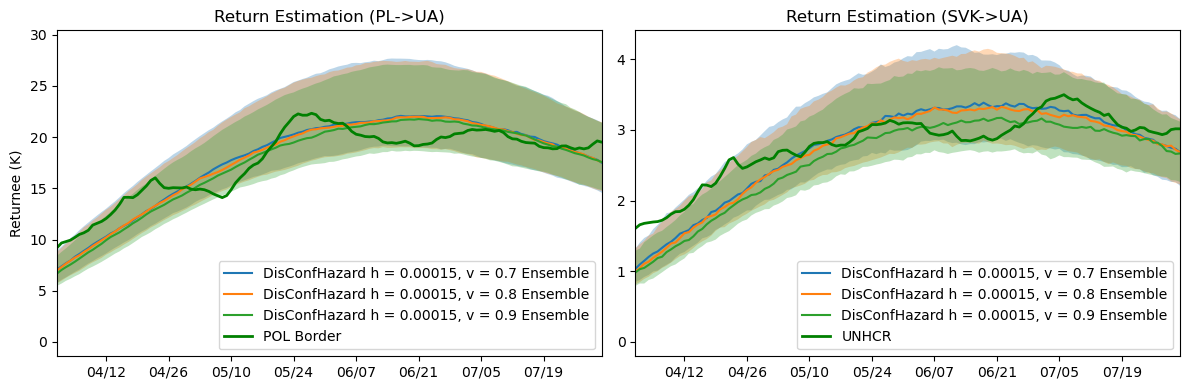

In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

all_sims = range(0,100)
fig,ax = plt.subplots(1,2,figsize=(6*2,4))
LEGEND_PARAMS = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':2,'ecolor':'black','size':12,'alpha':0.2}

myFmt = mdates.DateFormatter('%m/%d')

Q1 = 0.25
Q3 = 0.75

scale = 1e3

H_Rates = [0.00015]
V_Rates = [0.7,0.8,0.9]
RETURN_DIRS = [f'RETURN_HAZARD_constant_discounted_conflict_{h}_{v}/' for h in H_Rates for v in V_Rates]
#print(RETURN_DIRS)

for idx, r in enumerate(RETURN_DIRS):
    #print(r)
    return_ensemble_PL = get_ensemble_return_from_dest_for_param([r],all_sims,'PL',all_raions,q1=0.1,q3=0.9,cache_clean_mode=0)
    return_ensemble_SK = get_ensemble_return_from_dest_for_param([r],all_sims,'SK',all_raions,q1=0.1,q3=0.9,cache_clean_mode=0)
    ax[0].plot(return_ensemble_PL['return_date'],return_ensemble_PL['Total']/(scale),label=f'DisConfHazard h = 0.00015, v = {V_Rates[idx]} Ensemble')
    ax[0].fill_between(return_ensemble_PL['return_date'],return_ensemble_PL['q1']/(scale),return_ensemble_PL['q3']/(scale),alpha=0.3)
    ax[1].plot(return_ensemble_SK['return_date'],return_ensemble_SK['Total']/(scale),label=f'DisConfHazard h = 0.00015, v = {V_Rates[idx]} Ensemble')
    ax[1].fill_between(return_ensemble_SK['return_date'],return_ensemble_SK['q1']/(scale),return_ensemble_SK['q3']/(scale),alpha=0.3)
    print('v=',V_Rates[idx])
    print(calc_error(return_ensemble_PL,ukr_people_depart_poland_by_date,gt_cols=['Date','Depart'],gt_scale=1.2),'PL')
    print(calc_error(return_ensemble_SK,svk_ukr_depart_df,gt_cols=['data_date','individuals']),'SK')

ax[0].plot(ukr_people_depart_poland_by_date['Date'],ukr_people_depart_poland_by_date['Depart']/(1.0*scale*1.2),label='POL Border',color='green',linewidth=2)  
ax[1].plot(svk_ukr_depart_df['data_date'],svk_ukr_depart_df['individuals']/(1.0*scale),label='UNHCR',color='green',linewidth=2)

myFmt = mdates.DateFormatter('%m/%d')
for i in range(2):
    ax[i].legend(loc='best')
    ax[i].xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    ax[i].xaxis.set_major_formatter(myFmt)
    ax[i].set_xlim([pd.to_datetime('2022-04-01'),pd.to_datetime('2022-08-01')])
ax[0].set_title(f'Return Estimation (PL->UA)')
ax[1].set_title(f'Return Estimation (SVK->UA)')
ax[0].set_ylabel('Returnee (K)')

fig.tight_layout()
#fig.savefig('return_constant_discounted_conflict_hazard.png',dpi=350,bbox_inches='tight')